### Do your imports!

In [1]:
import pandas as pd

df = pd.read_csv("subset.csv",nrows=2000000)


C:\Users\nao22\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 311 data analysis

## Read in `subset.csv` and review the first few rows

Even though it's a giant file – gigs and gigs! – it's a subset of the [entire dataset](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9). It covers plenty of years, but not all of the columns.

If your computer is struggling (which it will!) or you are impatient, feel free to use `nrows=` when reading it in to speed up the process by only reading in a subset of columns. Pull in at least a few million, or a couple years back.

In [2]:
#Done obove

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 15 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Unique Key              int64 
 1   Created Date            object
 2   Closed Date             object
 3   Agency                  object
 4   Agency Name             object
 5   Complaint Type          object
 6   Descriptor              object
 7   Location Type           object
 8   Incident Zip            object
 9   Incident Address        object
 10  Address Type            object
 11  City                    object
 12  Status                  object
 13  Borough                 object
 14  Open Data Channel Type  object
dtypes: int64(1), object(14)
memory usage: 228.9+ MB


### Where the subset came from

If you're curious, I took the [original data](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/data) and clipped out a subset by using the command-line tool [csvkit](https://csvkit.readthedocs.io/en/latest/).

First I inspected the column headers:

```bash
$ csvcut -n 311_Service_Requests_from_2010_to_Present.csv 
```

Then I selected the columns I was interested in and saved it to a file.

```bash
$ csvcut -c 1,2,3,4,5,6,7,8,9,10,16,17,20,26,29 311_Service_Requests_from_2010_to_Present.csv > subset.csv
```

This was much much much much faster than doing it in Python.

## We want more columns!

**Right now we don't see all of the columns.** For example, mine has `...` between the **Incident Address** column and the **City** column. Go up to the top where you imported pandas, and add a `pd.set_option` line that will allow you to view all of the columns of the dataset.

In [3]:
# DONE above

## We hate those column names!

Change the column names to be tab- and period-friendly, like `df.created_date` instead of `df['Created Date']`

In [6]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 15 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   unique_key              int64 
 1   created_date            object
 2   closed_date             object
 3   agency                  object
 4   agency_name             object
 5   complaint_type          object
 6   descriptor              object
 7   location_type           object
 8   incident_zip            object
 9   incident_address        object
 10  address_type            object
 11  city                    object
 12  status                  object
 13  borough                 object
 14  open_data_channel_type  object
dtypes: int64(1), object(14)
memory usage: 228.9+ MB


# Dates and times

## Are the datetimes actually datetimes?

We're going to be doing some datetime-y things, so let's see if the columns that look like dates are actually dates.

In [5]:
df.created_date.dt.year
#Error
df.closed_date.dt.year

#Error


AttributeError: Can only use .dt accessor with datetimelike values

## In they aren't datetimes, convert them

The ones we're interested in are as follows:

* Created Date
* Closed Date

You have two options to convert them:

1. Do it like we did in class, but **overwrite the existing string columns with the new datetime versions**
2. Find an option with `read_csv` to automatically read certain columns as dates! Use the shift+tab trick to read the `read_csv` docs to uncover it. Once you find it, you'll set it to be the **list of date-y columns**.

They're both going to take forever if you do them wrong, but can be faster with a few tricks. For example, using `pd.to_datetime` can be sped up significantly be specifying the format of the datestring.

For example, if your datetime was formatted as `YYYY-MM-DD HH:MM:SS AM`, you could use the following:

```
df.my_datetime = pd.to_datetime(df.my_datetime, format="%Y-%m-%d %I:%M:%S %p")
```

It's unfortunately much much much faster than the `read_csv` technique. And yes, [that's `%I` and not `%H`](https://strftime.org/).

> *Tip: What should happen if it encounters an error or missing data?*

In [7]:
df['create_date_dtime'] = pd.to_datetime(df.created_date, format="%m/%d/%Y %I:%M:%S %p")
df.create_date_dtime


0         2019-01-27 19:26:21
1         2019-01-29 11:06:56
2         2019-02-13 12:28:18
3         2019-02-13 15:40:19
4         2019-02-13 13:18:31
                  ...        
1999995   2010-09-14 00:00:00
1999996   2010-09-14 00:00:00
1999997   2010-09-14 08:27:00
1999998   2010-09-14 09:40:00
1999999   2010-09-14 00:00:00
Name: create_date_dtime, Length: 2000000, dtype: datetime64[ns]

In [8]:
df['closed_date_dtime'] = pd.to_datetime(df.closed_date, format="%m/%d/%Y %I:%M:%S %p")
df.closed_date_dtime


0         2019-02-13 10:53:25
1         2019-02-13 02:07:22
2         2019-03-15 09:54:50
3         2019-02-20 06:18:35
4         2019-02-20 05:36:54
                  ...        
1999995   2010-09-20 00:00:00
1999996   2010-09-20 00:00:00
1999997   2010-09-14 09:20:00
1999998   2010-09-14 09:40:00
1999999   2010-09-17 00:00:00
Name: closed_date_dtime, Length: 2000000, dtype: datetime64[ns]

## According to the dataset, which month of the year has the most 311 calls?

The kind of answer we're looking for is "January," not "January 2021"

In [ ]:
# there are two big techniques for date stuff: .dt or .resample
# if you use one of those, explain why you picked that one and not the other

In [9]:
# use .dt bcoz I only want to select particular data

df.create_date_dtime.dt.month.value_counts()

#June

3     310996
5     283984
4     272387
2     219980
6     202440
1     185675
8     127039
7      85805
11     84139
9      82620
12     77096
10     67839
Name: create_date_dtime, dtype: int64

## According to the dataset, which month has had the most 311 calls?

The kind of answer we're looking for is "January 2021," not "January" (although _techniucally_ it will say `2021-01-31`, not `January 2021`)

In [ ]:
# there are two big techniques for date stuff: .dt or .resample
# if you use one of those, explain why you picked that one and not the other

In [10]:
# use .resample bcoz I only want to select summerize particular data

df.resample('M', on='create_date_dtime').size().sort_values()

create_date_dtime
2021-01-31         1
2020-11-30        10
2020-10-31        10
2020-12-31        42
2020-09-30        52
               ...  
2010-01-31    110336
2019-06-30    131567
2019-04-30    190340
2019-03-31    198597
2019-05-31    213287
Length: 133, dtype: int64

## Plot the 311 call frequency over our dataset on a _weekly_ basis

To make your y axis start at zero, use `ylim=(0,100000)` when doing `.plot`. But replace the `1000` with a large enough value to actually see your data nicely!

In [ ]:
# there are two big techniques for date stuff: .dt or .resample
# if you use one of those, explain why you picked that one and not the other

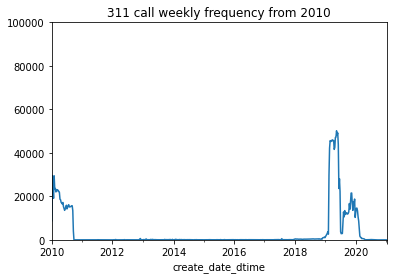

In [11]:
# use .resample bcoz I only want to select summerize particular data

weekly_chart = df.resample('W', on='create_date_dtime').size().plot(ylim=[0,100000], title = "311 call weekly frequency from 2010")



## What time of day (by hour) is the least common for 311 complains? The most common? 







In [ ]:
# there are two big techniques for date stuff: .dt or .resample
# if you use one of those, explain why you picked that one and not the other

In [13]:
# use .resample bcoz I only want to select summerize particular data
# df.resample('H', on='create_date_dtime').size().sort_values()

# df.create_date_dtime.dt.month.value_counts()




df.create_date_dtime.dt.hour.value_counts()

# least common: 4am, most common:10am ????really???????


0     462108
10    126013
11    121702
9     118715
14    111539
12    110884
13    104162
15     97250
8      86302
16     84504
17     70278
18     66516
19     63623
21     59502
20     58851
22     56726
7      51713
23     46968
6      26909
1      23540
2      15067
5      14046
3      11899
4      11183
Name: create_date_dtime, dtype: int64

### Make a graph of the results

* Make sure the hours are in the correct order
* Be sure to set the y-axis to start at 0
* Give your plot a descriptive title

# Agencies

## What agencies field the most complaints in the dataset? Get the top 5.

Use the `agency` column for this one.

In [ ]:
df.agency.value_counts().head(5)


## What are each of those agencies?

Define the following five acronyms:

* NYPD
* HPD
* DOT
* DSNY
* DEP

NYPD: New York City Police Department
HPD:New York City Department of Housing Preservation and Development
DOT:New York City Department of Transportation
DSNY:New York City Department of Sanitation
DEP: New York City Department of Environmental Protection

## What is the most common complaint to HPD?

In [ ]:
# Why did you pick these columns to calculate the answer?

In [14]:
# I used complaint_type because this captures each category of complaints

HPD_df = df[df.agency == 'HPD']
HPD_df.head()

HPD_df.complaint_type.value_counts().head(5)
#HEAT/HOT WATER 

HEAT/HOT WATER          181490
PLUMBING                108389
HEATING                 104477
GENERAL CONSTRUCTION     87698
PAINT - PLASTER          65400
Name: complaint_type, dtype: int64

## What are the top 3 complaints to each agency?

You'll want to use the weird confusing `.groupby(level=...` thing we learned when reviewing the homework.


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 17 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   unique_key              int64         
 1   created_date            object        
 2   closed_date             object        
 3   agency                  object        
 4   agency_name             object        
 5   complaint_type          object        
 6   descriptor              object        
 7   location_type           object        
 8   incident_zip            object        
 9   incident_address        object        
 10  address_type            object        
 11  city                    object        
 12  status                  object        
 13  borough                 object        
 14  open_data_channel_type  object        
 15  create_date_dtime       datetime64[ns]
 16  closed_date_dtime       datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(14)
mem

In [16]:
# merged.groupby(by='neighborhood')['Primary Breed'] \
#     .value_counts() \
#     .groupby(level=0, group_keys=False) \
#     .nlargest(1)

# merged.groupby('neighborhood')['Primary Breed'] \
#     .value_counts() \
#     .groupby(level=0) \
#     .head(1)

df.groupby(['agency']).complaint_type.value_counts().groupby(level=0, group_keys=False).nlargest(3)

agency  complaint_type                     
ACS     Forms                                     117
COIB    Forms                                       4
DCA     Consumer Complaint                       4240
DCAS    Question                                  261
        Comments                                   19
DCP     Research Questions                          9
DEP     Noise                                   41563
        Water System                            37463
        Sewer                                   21251
DFTA    Housing - Low Income Senior              1589
        Housing Options                           507
        Senior Center Complaint                    64
DHS     Homeless Person Assistance                483
DOB     General Construction/Plumbing           80000
        Elevator                                34933
        Building/Use                            34693
DOE     School Maintenance                        358
        Teaching/Learning/Instruction 

## What is the most common kind of residential noise complaint?

The NYPD seems to deal with a lot of noise complaints at homes. What is the most common subtype?

In [17]:
# Why did you pick these columns to calculate the answer?
df.complaint_type.value_counts()

HEAT/HOT WATER                    181490
PLUMBING                          108389
Street Light Condition            107147
Street Condition                  106381
HEATING                           104477
                                   ...  
Misc. Comments&quot;                   1
Misc. Comments&amp;ping -n ...         1
...\.\...\.\...\.\...\.\......         1
.../...//.../...//.../...//...         1
Teaching/Learning/Instruction          1
Name: complaint_type, Length: 304, dtype: int64

In [18]:
res_noise_df = df[df.complaint_type == "Noise - Residential"]

res_noise_df.descriptor.value_counts()

Loud Music/Party    47675
Banging/Pounding    21348
Loud Talking         5304
Loud Television      1524
Name: descriptor, dtype: int64

## What time of day do "Loud Music/Party" complaints come in? Make it a chart!

In [ ]:
# there are two big techniques for date stuff: .dt or .resample
# if you use one of those, explain why you picked that one and not the other

<AxesSubplot:>

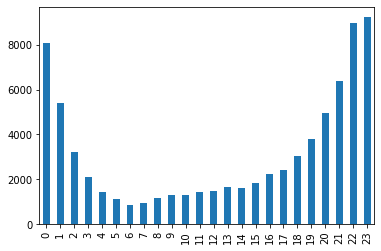

In [19]:
res_noise_df.create_date_dtime.dt.hour.value_counts().sort_index().plot(kind= 'bar')


## <span style="color: red; ">When do people party hard?

Make a monthly chart of Loud Music/Party complaints since the beginning of the dataset. Make it count them on a biweekly basis (every two weeks).

In [ ]:
# there are two big techniques for date stuff: .dt or .resample
# if you use one of those, explain why you picked that one and not the other
res_noise_df.descriptor.isna().sum()

<AxesSubplot:xlabel='create_date_dtime'>

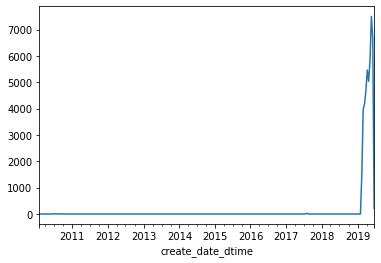

In [20]:
res_noise_df_nan = res_noise_df.dropna()

res_noise_df_nan[res_noise_df_nan.descriptor == "Loud Music/Party"].resample('2W', on='create_date_dtime').size().plot()



## People and their bees

Sometimes people complain about bees! Why they'd do that, I have no idea. It's somewhere in "complaint_type" – can you find all of the bee-related complaints?

In [21]:
bee_df = df[df.complaint_type.str.contains('bee', case= False)]
bee_df.complaint_type.value_counts()

Harboring Bees/Wasps    16
Name: complaint_type, dtype: int64

### <span style="color: red; ">What month do most of the complaints happen in? I'd like to see a graph.


<AxesSubplot:>

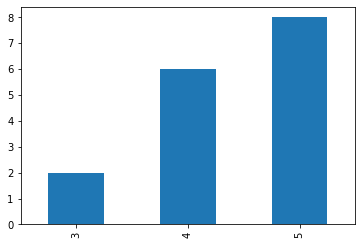

In [22]:
# df.create_date_dtime.dt.month.value_counts()

bee_df.create_date_dtime.dt.month.value_counts().sort_values().plot(kind= 'bar')




### Are the people getting in trouble usually beekeepers or not beekeepers?

In [ ]:
# bee_df.complaint_type.str.contains('not beekeeper', case= False).value_counts()


bee_df.descriptor.value_counts()
#Not beekeeper

# Math with datetimes

## How long does it normally take to resolve a 311 complaint?
    
   
Even if we didn't cover this in class, I have faith that you can guess how to calculate it.

In [23]:
# #there is no NaN in create_date_dtime
df.closed_date_dtime.isna().value_counts()

False    1991095
True        8905
Name: closed_date_dtime, dtype: int64

In [ ]:
# df.closed_date_dtime = df.closed_date_dtime.fillna(0)

In [24]:
# df.closed_date_dtime.tail(2)

# 27098879    2019-02-15 15:55:51
# 27098880    2019-02-15 15:25:09

df.create_date_dtime.tail(2)

1999998   2010-09-14 09:40:00
1999999   2010-09-14 00:00:00
Name: create_date_dtime, dtype: datetime64[ns]

In [25]:
# df.closed_date_dtime = pd.to_datetime(df.closed_date_dtime, format="%Y-%m-%d %H:%M:%S", errors='coerce')

time_diff = df['closed_date_dtime'] - df['create_date_dtime']
time_diff

0         16 days 15:27:04
1         14 days 15:00:26
2         29 days 21:26:32
3          6 days 14:38:16
4          6 days 16:18:23
                ...       
1999995    6 days 00:00:00
1999996    6 days 00:00:00
1999997    0 days 00:53:00
1999998    0 days 00:00:00
1999999    3 days 00:00:00
Length: 2000000, dtype: timedelta64[ns]

In [26]:
time_diff.dt.total_seconds().median()

226320.0

Save it as a new column called `time_to_fix`

In [32]:
df['time_to_fix'] = time_diff.dt.total_seconds()

## Which agency has the best time-to-fix time?

In [33]:
#'time_to_fix' is new column

df.groupby(by='agency').time_to_fix.median().sort_values()

# DHS        average 4383.0 seconds

agency
DHS         4383.0
NYPD        9167.0
DOT        62663.0
DEP        79440.0
DSNY      175920.0
DPR       246899.5
DOHMH     297188.0
DCA       310351.0
DOE       361143.0
HPD       518400.0
DOB       889639.5
DOF       939321.0
DFTA     1057014.5
DOITT    1272655.0
EDC      1644113.0
TLC      3848216.0
ACS            NaN
COIB           NaN
DCAS           NaN
DCP            NaN
DVS            NaN
TAX            NaN
Name: time_to_fix, dtype: float64

## Maybe we need some more information...

I might want to know how big our sample size is for each of those, maybe the high performers only have one or two instances of having requests filed!

### First, try using `.describe()` on the time to fix column after your `groupby`.

In [34]:
df.groupby(by='agency').describe()

unique_key                                                       \
            count          mean           std         min          25%   
agency                                                                   
ACS         117.0  4.229530e+07  4.093072e+05  41710210.0  41912271.00   
COIB          4.0  4.258125e+07  2.678087e+05  42258386.0  42415141.25   
DCA        4240.0  4.218055e+07  1.262790e+06  15773785.0  41946836.75   
DCAS        280.0  4.229537e+07  4.011786e+05  41700997.0  41959548.25   
DCP           9.0  4.238449e+07  5.212491e+05  41717530.0  41947840.00   
DEP      119455.0  4.285930e+07  3.009645e+06  15635861.0  42252954.00   
DFTA       2286.0  4.221565e+07  3.325507e+05  41694656.0  41934018.50   
DHS         483.0  4.232518e+07  4.305532e+05  41696926.0  42134661.50   
DOB      209122.0  3.432049e+07  1.231766e+07  15636311.0  18254053.25   
DOE         359.0  4.253006e+07  1.913849e+06  18658028.0  41951006.00   
DOF        2408.0  4.206774e+07  7.601930e+05  31835193.0  41912167.75   
DOHMH     10592.0  4.209561e+07  8.500494e+05  15634405.0  41912483.75   
DOITT       153.0  4.188743e+07  2.956290e+06  16228771.0  41947416.00   
DOT      287020.0  3.300320e+07  1.297234e+07  15631032.0  16695578.25   
DPR       13467.0  4.232205e+07  1.051000e+06  15901928.0  42005331.00   
DSNY     269979.0  3.563467e+07  1.177808e+07  15636100.0  18481554.00   
DVS         120.0  4.290163e+07  3.419230e+03  42895943.0  42898976.75   
EDC         148.0  4.201400e+07  1.356752e+05  41698232.0  41924544.00   
HPD      814775.0  2.967555e+07  1.343032e+07  15629728.0  16349373.50   
NYPD     261794.0  4.233965e+07  6.268887e+05  15650160.0  42022006.25   
TAX          86.0  4.235259e+07  4.437092e+05  41697670.0  41944663.25   
TLC        3103.0  4.170066e+07  3.190444e+06  15647824.0  41886111.50   

                                            time_to_fix                \
               50%          75%         max       count          mean   
agency                                                                  
ACS     42209401.0  42700716.00  42974968.0         0.0           NaN   
COIB    42615467.5  42781574.00  42835670.0         0.0           NaN   
DCA     42169763.0  42596068.50  42893918.0      4240.0  7.218840e+05   
DCAS    42188893.0  42678320.75  42970700.0         0.0           NaN   
DCP     42704587.0  42807355.00  42904520.0         0.0           NaN   
DEP     42988461.0  43859251.00  47371726.0    117430.0  5.005384e+05   
DFTA    42158801.5  42532731.50  42886759.0      2286.0  9.755638e+05   
DHS     42241013.0  42298694.50  47878609.0       482.0  1.111270e+04   
DOB     42382270.0  42868592.25  47238123.0    209122.0  5.206282e+06   
DOE     42141178.0  42599961.50  48376037.0       354.0  1.875025e+06   
DOF     42076702.5  42295510.25  43048380.0      2408.0  1.308866e+06   
DOHMH   42062898.5  42226810.25  43140933.0     10509.0  6.797598e+05   
DOITT   42141559.0  42523797.00  42774205.0       153.0  1.324224e+06   
DOT     42078623.5  43372586.25  47297871.0    283114.0  4.447302e+05   
DPR     42252786.0  42675024.50  47919087.0     13454.0  7.762200e+05   
DSNY    42231260.0  42963661.50  49497177.0    268788.0  3.849571e+05   
DVS     42901837.5  42904799.25  42906250.0         0.0           NaN   
EDC     42037413.0  42117198.50  42224486.0       148.0  1.826095e+06   
HPD     18617074.0  43040604.50  47221250.0    813710.0  1.077827e+06   
NYPD    42276206.0  42709748.75  47315114.0    261794.0  1.504997e+04   
TAX     42253204.5  42799701.00  42976519.0         0.0           NaN   
TLC     42035341.0  42202861.50  43125447.0      3103.0  3.671171e+06   

                                                                       \
                 std           min         25%        50%         75%   
agency                                                                  
ACS              NaN           NaN         NaN        NaN         NaN   
COIB             NaN           NaN    

### Now, an alternative

Seems a little busy, yeah? **You can also do smaller, custom aggregations.**

Try something like this:

```python
# Multiple aggregations of one column
df.groupby('agency').time_to_fix.agg(['median', 'size'])

# You can also do something like this to reach multiple columns
df.groupby('agency').agg({
    'time_to_fix': ['median', 'size']
})
```

In [35]:
df.groupby('agency').time_to_fix.agg(['median', 'size'])

,median,size
agency,,
ACS,NaN,117
COIB,NaN,4
DCA,310351.0,4240
DCAS,NaN,280
DCP,NaN,9
DEP,79440.0,119455
DFTA,1057014.5,2286
DHS,4383.0,483
DOB,889639.5,209122


In [36]:
df.groupby('agency').agg({
    'time_to_fix': ['median', 'size']
})

time_to_fix        
            median    size
agency                    
ACS            NaN     117
COIB           NaN       4
DCA       310351.0    4240
DCAS           NaN     280
DCP            NaN       9
DEP        79440.0  119455
DFTA     1057014.5    2286
DHS         4383.0     483
DOB       889639.5  209122
DOE       361143.0     359
DOF       939321.0    2408
DOHMH     297188.0   10592
DOITT    1272655.0     153
DOT        62663.0  287020
DPR       246899.5   13467
DSNY      175920.0  269979
DVS            NaN     120
EDC      1644113.0     148
HPD       518400.0  814775
NYPD        9167.0  261794
TAX            NaN      86
TLC      3848216.0    3103

## Seems weird that NYPD time-to-close is so fast. Can we break that down by complaint type?

Remember the order: 

1. Filter
2. Group
3. Grab a column
4. Do something with it
5. Sort

In [37]:
df[df.agency =='NYPD'].groupby(by='complaint_type').time_to_fix.median().sort_values()



complaint_type
Illegal Fireworks               5085.5
Noise - Vehicle                 5937.0
Traffic                         6653.0
Noise - House of Worship        6922.0
Traffic/Illegal Parking         6949.0
Bike/Roller/Skate Chronic       7109.0
Noise - Park                    7215.0
Noise - Commercial              7257.0
Noise - Street/Sidewalk         7440.0
Non-Emergency Police Matter     8541.0
Drinking                        8573.5
Urinating in Public             8587.0
Noise - Residential             8827.0
Vending                         8975.5
Panhandling                     9034.0
Disorderly Youth                9244.0
Homeless Encampment             9814.0
Illegal Parking                 9936.0
Graffiti                       10266.0
Blocked Driveway               11287.0
Drug Activity                  11631.0
Posting Advertisement          11717.0
Animal Abuse                   11855.5
Derelict Vehicle               13352.0
Name: time_to_fix, dtype: float64

## Back to median fix time for all agencies: do these values change based on the borough?

First, use `groupby` to get the median time to fix per agency in each borough. You can use something like `pd.set_option("display.max_rows", 200)` if you can't see all of the results by default!

In [38]:
df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,address_type,city,status,borough,open_data_channel_type,create_date_dtime,closed_date_dtime,time_to_fix
0,41694420,01/27/2019 07:26:21 PM,02/13/2019 10:53:25 AM,HPD,Department of Housing Preservation and Develop...,GENERAL,BELL/BUZZER/INTERCOM,RESIDENTIAL BUILDING,11216,30 MAC DONOUGH STREET,ADDRESS,BROOKLYN,Closed,BROOKLYN,PHONE,2019-01-27 19:26:21,2019-02-13 10:53:25,1438024.0
1,41694421,01/29/2019 11:06:56 AM,02/13/2019 02:07:22 AM,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,CEILING,RESIDENTIAL BUILDING,10453,30 RICHMAN PLAZA,ADDRESS,BRONX,Closed,BRONX,PHONE,2019-01-29 11:06:56,2019-02-13 02:07:22,1263626.0
2,41694422,02/13/2019 12:28:18 PM,03/15/2019 09:54:50 AM,DOF,External Affairs Unit,DOF Property - Payment Issue,Bill Received in Error,Property Address,11412,120-25 200 STREET,ADDRESS,SAINT ALBANS,Closed,QUEENS,PHONE,2019-02-13 12:28:18,2019-03-15 09:54:50,2582792.0
3,41694423,02/13/2019 03:40:19 PM,02/20/2019 06:18:35 AM,DOT,Department of Transportation,Broken Parking Meter,Out of Order,Street,11377,NaN,INTERSECTION,WOODSIDE,Closed,QUEENS,PHONE,2019-02-13 15:40:19,2019-02-20 06:18:35,571096.0
4,41694424,02/13/2019 01:18:31 PM,02/20/2019 05:36:54 AM,DOT,Department of Transportation,Broken Parking Meter,Out of Order,Street,10461,1082 MORRIS PARK AVENUE,ADDRESS,BRONX,Closed,BRONX,PHONE,2019-02-13 13:18:31,2019-02-20 05:36:54,577103.0


In [ ]:
pd.set_option("display.max_rows", 200)


# borough
# Unspecified       58957.0
# QUEENS            85680.0
# MANHATTAN        102906.0
# BROOKLYN         113220.0
# STATEN ISLAND    140220.0
# BRONX            180862.0

df[df.borough =='QUEENS'].groupby(by='agency').time_to_fix.median().sort_values()
df[df.borough =='MANHATTAN'].groupby(by='agency').time_to_fix.median().sort_values()
df[df.borough =='BROOKLYN'].groupby(by='agency').time_to_fix.median().sort_values()
df[df.borough =='STATEN ISLAND'].groupby(by='agency').time_to_fix.median().sort_values()
df[df.borough =='BRONX'].groupby(by='agency').time_to_fix.median().sort_values()


### Or, use another technique!

We talked about pivot table for a hot second in class, but it's (potentially) a good fit for this situation:

```python
df.pivot_table(
    columns='what will show up as your columns',
    index='what will show up as your rows',
    values='the column that will show up in each cell',
    aggfunc='the calculation(s) you want dont'
)
```

In [39]:

boro_pivot = df.pivot_table(
    columns='borough',
    index='agency',
    values='time_to_fix',
    aggfunc='median'
)


boro_pivot.columns = boro_pivot.columns.str.lower().str.replace(" ", "_")

boro_pivot

borough,bronx,brooklyn,manhattan,queens,staten_island,unspecified
agency,,,,,,
DCA,336461.0,264918.5,244253.0,332825.0,318603.0,1334579.0
DEP,73830.0,72480.0,103500.0,67200.0,67290.0,25920.0
DFTA,1109447.0,1057959.0,1048982.0,1061454.0,1127806.5,658802.0
DHS,4943.0,5943.0,4122.0,3056.0,15357.5,NaN
DOB,1255744.0,809074.0,716627.0,1003363.0,560577.0,NaN
DOE,330030.0,234686.0,353808.0,441562.0,666097.0,1013794.0
DOF,1042593.5,959311.5,791397.0,882316.0,817472.0,NaN
DOHMH,172800.0,345600.0,259200.0,432000.0,604800.0,1357439.0
DOITT,1266807.0,1202002.0,1234148.5,1395978.0,1547226.0,NaN


### Use the pivot table result to find the worst-performing agency in the Bronx, then compare with Staten Island

Since it's a dataframe, you can use the power of `.sort_values` (twice!). Do any of the agencies have a large difference between the two?

In [ ]:
boro_pivot.staten_island.sort_values(ascending =False)

In [ ]:
boro_pivot.bronx.sort_values(ascending =False)

## What were the top ten 311 types of complaints on Thanksgiving 2020? Are they different than the day before Thanksgiving?

**Finding exact dates is awful, honestly.** While you can do something like this to ask for rows after a specific date:

```python
df[df.date_column >= '2020-01-01']
```

You, for some reason, can't ask for an **exact match** unless you're really looking for exactly at midnight. For example, this won't give you what you want:

```python
df[df.date_column == '2020-01-01']
```

Instead, the thing you need to do is this:

```python
df[(df.date_column >= '2020-01-01') & (df.date_column < '2020-01-02']
```

Everything that starts at midnight on the 1st but *is still less than midnight on the 2nd**.

In [40]:
# Here I assume these codes below work if I read the whole .csv file (I removed some rows below already)

In [41]:
df[(df.create_date_dtime >= '2020-11-26') & (df.create_date_dtime < '2020-11-27')].complaint_type.value_counts().head(3)

Series([], Name: complaint_type, dtype: int64)

In [42]:
df[(df.create_date_dtime >= '2020-11-25') & (df.create_date_dtime < '2020-11-26')].complaint_type.value_counts().head(3)

Series([], Name: complaint_type, dtype: int64)

## What is the most common 311 complaint types on Christmas day?

And I mean *all Christmas days*, not just in certain years)

* Tip: `dt.` and `&` are going to be your friend here
* Tip: If you want to get fancy you can look up `strftime`
* Tip: One of those is much much faster than the other

In [46]:
df['date_only'] = df.create_date_dtime.dt.strftime("%B%d")

In [44]:
df[df.date_only == "December25"].descriptor.value_counts()

ENTIRE BUILDING                                              443
APARTMENT ONLY                                               221
Pothole                                                       66
E3 Dirty Sidewalk                                             31
Elevator - Single Device On Property/No Alternate Service     27
                                                            ... 
WINDOW PANE                                                    1
POWER OUTAGE                                                   1
Hydrant Running Full (WA4)                                     1
Other Sewer Problem (Use Comments) (SZZ)                       1
CABINET                                                        1
Name: descriptor, Length: 97, dtype: int64

# Stories

Let's approach this from the idea of **having stories and wanting to investigate them.** Fun facts:

* Not all of these are reasonably answered with what our data is
* We only have certain skills about how to analyzing the data
* There are about six hundred approaches for each question

But: **for most of these prompts there are at least a few ways you can get something interesting out of the dataset.**

## Fireworks and BLM

You're writing a story about the anecdotal idea that the summer of the BLM protests there were an incredible number of fireworks being set off. Does the data support this?

What assumptions is your analysis making? What could make your analysis fall apart?

In [47]:
df[df.complaint_type.str.contains('fire', case=False)].complaint_type.value_counts()

Illegal Fireworks    32
Name: complaint_type, dtype: int64

In [48]:
#Assume the BLM protests intensifid after the murder of George Floyd(May 26.2020) 
## and it lasts at around three months (Aug. 26,2020)
### Then count "Illegal Fireworks" in complaint_type

BLM_fire = df[(df.create_date_dtime >= '2020-05-26') & (df.create_date_dtime < '2020-08-27')]
BLM_fire[BLM_fire.complaint_type  == "Illegal Fireworks"].complaint_type.value_counts()

# Then compares with the median data in the same period (May26 to August27)
## convert date_only in datetime data

BLM_fire = df[(df.create_date_dtime >= '2019-05-26') & (df.create_date_dtime < '2019-08-27')]
BLM_fire[BLM_fire.complaint_type  == "Illegal Fireworks"].complaint_type.value_counts()

# if the number of complaits about "illegal fireworks" between two years do not change,the anecdotes might be denied.
##else: I would go further and find locations and time that these complaints came from and see the relation between these data
### and the location of the protests taken place.

Illegal Fireworks    21
Name: complaint_type, dtype: int64

## Sanitation and work slowdowns

The Dept of Sanitation recently had a work slowdown to protest the vaccine mandate. You'd like to write about past work slowdowns that have caused garbage to pile up in the street, streets to not be swept, etc, and compare them to the current slowdown. You've also heard rumors that it was worse in Staten Island and a few Brooklyn neighborhoods - Marine Park and Canarsie - than everywhere else.

Use the data to find timeframes worth researching, and note how this slowdown might compare. Also, is there anything behind the geographic issue?

What assumptions is your analysis making? What could make your analysis fall apart?

In [49]:
# I look up reports handled by DSNY and see how many complaint_type== "Missed Collection (All Materials)" reports filed after 2021-11-1
## Vaccine mandate went into effect on 2021-11-1(https://abc7ny.com/nyc-sanitation-department-workers-vaccine-mandates-garbage/11188418/)

DSNY_df = df[df.agency == "DSNY"]

#Then see if there is any change a week after vaccine mandate went into effect and the same period in the previous year. 

DSNY_after_mandate = DSNY_df[(DSNY_df.create_date_dtime >= '2021-11-01') & (DSNY_df.create_date_dtime < '2021-11-09')]

#As 2020-11-01 is Sunday when there is no gabage collection anyway, so I moved the priod a day after
DSNY_before_mandate = DSNY_df[(DSNY_df.create_date_dtime >= '2020-11-02') & (DSNY_df.create_date_dtime < '2020-11-10')]

DSNY_after_mandate[DSNY_after_mandate.complaint_type =="Missed Collection (All Materials)"].value_counts()
DSNY_before_mandate[DSNY_before_mandate.complaint_type =="Missed Collection (All Materials)"].value_counts()

#compare there two data

Series([], dtype: int64)

## Gentrification and whining to the government

It's said that when a neighborhood gentrifies, the people who move in are quick to report things to authorities that would previously have been ignored or dealt with on a personal basis. Use the data to investigate the concept (two techniques for finding gentrifying area are using census data and using Google).

What assumptions is your analysis making? What could make your analysis fall apart? Be sure to cite your sources. 

In [ ]:
#Based on the article(https://www.rentcafe.com/blog/rental-market/real-estate-news/top-20-gentrified-zip-codes/)
#*the article is about the study on the 2000 Census and the 2016 American Community Survey)
## I defied these three NYC neighborhoods as most Gentrified
### neighborhoods with zipcode 10039, 11211, 11222 (Washington Heights, Williamsburg, Greenpoint)
### I look up the number of 311 reports and compare it over the years

#First, separate the data reported between a) 2013 to 2016 and b) 2016 to 2019
gen_df_a = df[(df.create_date_dtime >= '2013-01-01') & (df.create_date_dtime < '2016-01-01')]
gen_df_b = df[(df.create_date_dtime >= '2016-01-01') & (df.create_date_dtime < '2020-01-01')]

gen_df_a[gen_df_a.incident_zip.str.contains("10039|11211|11222", na=False)].incident_zip.value_counts()

# 11211    175
# 11222    114
# 10039     11


gen_df_b[gen_df_b.incident_zip.str.contains("10039|11211|11222", na=False)].incident_zip.value_counts()

# 11211    3966
# 11222    2890
# 10039    1421

# If there is no sifnificant increase between two periods, this story fails.

## 311 quirks

Our editor tried to submit a 311 request using the app the other day, but it didn't go through. As we all know, news is what happens to your editor! Has the 311 mobile app ever actually stopped working?

If that's a dead end, maybe you can talk about the differences between the different submission avenues: could a mobile outage disproportionately impact a certain kind of complaint or agency? How about if the phone lines stopped working?

What assumptions is your analysis making? What could make your analysis fall apart?

In [ ]:
# First, look up how many reports come from mobile app. 
# use "open_data_channel_type"

df.open_data_channel_type.value_counts(normalize = True)

#Around 10 % of reports come from mobile
#Around 46% of reports come from mobile

# Then see if there is any change by agency
df.groupby(by= 'open_data_channel_type').agency.value_counts(normalize = True)

# From mobile, over 70% of reports handled by NYPD
# From phone,only 20% of reports handled by NYPD
# From phone,30% of reports handled by HPD

## If mobile stop working, reports for NYPD will be affected a lot
## If phone stop working, reports for HPDll be affected a lot


## NYCHA and public funds

NYC's public housing infrastructure is failing, and one reason is lack of federal funds. While the recent spending bills passed through Congress might be able to help, the feeling is that things have really fallen apart in the past however-many years – as time goes on it gets more and more difficult for the agency in control of things to address issues in a timely manner.

If you were tasked with finding information to help a reporter writing on this topic, you will **not** reasonably be able to find much in the dataset to support or refute this. Why not? 

If you wanted to squeeze something out of this dataset anyway, what could an option be? (You might need to bring in another dataset.)

<AxesSubplot:>

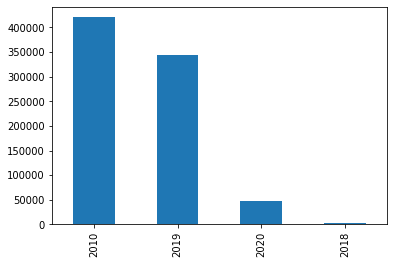

In [50]:
# Almost all reports on residential building are handled by HPD
HPD_df = df[df.agency == "HPD"]

#So compares the number of reports handled by HPD over the years
HPD_df.create_date_dtime.dt.year.value_counts().plot(kind='bar')

#But I need to further look up whether these complaints were from public housing. 
##To find it the data in here will be helpful(https://www1.nyc.gov/site/nycha/about/developments.page)

### Also, I need to see the federal funding amount to NYCHA over the years. 
##https://council.nyc.gov/budget/wp-content/uploads/sites/54/2021/03/NYCHA.pdf
##This document might be helpful, but it seems like the federal funding to NYCHA is increasing over five years...why?!